## Part 2. Model Training & Evaluation - RNN   
Now with the pretrained word embeddings acquired from Part 1 and the dataset acquired from
Part 0, you need to train a deep learning model for sentiment classification using the training set,
conforming to these requirements:


• Use the pretrained word embeddings from Part 1 as inputs; do not update them during training
(they are “frozen”).   

• Design a simple recurrent neural network (RNN), taking the input word embeddings, and
predicting a sentiment label for each sentence. To do that, you need to consider how to
aggregate the word representations to represent a sentence.   

• Use the validation set to gauge the performance of the model for each epoch during training.
You are required to use accuracy as the performance metric during validation and evaluation. 
   
• Use the mini-batch strategy during training. You may choose any preferred optimizer (e.g.,
SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and
mini-batch size. (You should use the validation set to determine the optimal configuration.)
Train the model until the accuracy score on the validation set is not increasing for a few
epochs.
   
• Evaluate your trained model on the test dataset, observing the accuracy score.

Import dependencies

In [18]:
import json
# We omit warnings to keep the output clean
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt 

from common_utils import load_glove_embeddings, set_seed
import nltk

In [26]:
# set seed 
set_seed()

In [3]:
# initialize parameters
BATCH_SIZE = 32
INPUT_SIZE = 100 # word embedding size 
HIDDEN_SIZE = 128 # just as a starter to see 
NUM_EPOCHS = 100 
EMBEDDING_DIM=100

In [5]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [6]:
# initialize word embeddings
word_embeddings = load_glove_embeddings()

Loading GloVe embeddings...


Repo card metadata block was not found. Setting CardData to empty.


Total GloVe words loaded: 400000


In [ ]:
embeddings = [word_embeddings[word] for word in word_embeddings.keys()]

embedding_matrix_np = np.array(embeddings)
embedding_matrix_np = np.vstack((embedding_matrix_np, np.zeros((1, INPUT_SIZE))))

embedding_matrix_np.shape 


(400001, 100)

In [21]:
# check the padding token has been added
print(embedding_matrix_np[-1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [8]:
# load dataset from huggingface first 
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

with open('result/word2idx.json', "r") as file:
    word2idx = json.load(file)

In [22]:
from torch.utils.data import Dataset, DataLoader 

# TODO: change the num_tokens 
class EmbeddingsDataset(Dataset):
  def __init__(self, X, y, num_tokens_per_sentence=20, word_embeddings=word_embeddings):
    self.num_tokens_per_sentence = num_tokens_per_sentence
    self.word_embeddings = word_embeddings
    self.X = X # train_dataset['text']
    self.y = y # train_dataset['label']
    self.len = len(self.X)

  def __getitem__(self, index):
    # tokenize the sentence 
    tokens = self.tokenize_sentence(self.X[index])
    # convert each token to embeddings 
    sentence_tensor = self.convert_sentence_into_indices(tokens)
    label = torch.tensor(self.y[index], dtype=torch.long)
    return sentence_tensor, label 

  def __len__(self):
    return self.len 

  def tokenize_sentence(self, x): 
    '''
    returns a list containing the embeddings of each token 
    '''
    tokens = nltk.word_tokenize(x.lower())
    return tokens 
  
  def convert_sentence_into_indices(self, tokens):
    indices = []
    num_tokens_used = 0 
    for token in tokens:
      if num_tokens_used == self.num_tokens_per_sentence:
        break # we have enough of tokens from the sentence 
      if token in word2idx:
        indices.append(word2idx[token])
        num_tokens_used += 1 
    # # if not enough tokens in the sentence, use index of ?? 
    if len(indices) < self.num_tokens_per_sentence:
      padding = [(embedding_matrix_np.shape[0] - 1 ) for _ in range(self.num_tokens_per_sentence - len(indices))]
      indices.extend(padding)
    #print(indices)
    indices = torch.tensor(indices, dtype=torch.long)
    return indices
  

In [23]:
def train_loop_bce(train_dataloader, model, loss_fn, optimizer):
    if train_on_gpu:
        model.cuda()
    model.train()
    num_batches = len(train_dataloader)
    size = len(train_dataloader.dataset)
    train_loss, train_correct = 0, 0
    for batch_no, (X_batch, y_batch) in enumerate(train_dataloader):
        y_batch = y_batch.long()
        if train_on_gpu:
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()
        
        # Forward pass
        pred = model(X_batch)
        #print(pred, y_batch)
        pred = pred.squeeze(1)
        y_val = y_batch
        loss = loss_fn(pred, y_val.float())
        train_loss += loss.item() 
        train_correct += ((pred >= 0.5).long()==y_batch).sum().item() 
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= num_batches 
    train_correct /= size 

    return train_loss, train_correct 
   

def test_loop_bce(validate_dataloader, model, loss_fn):
    if train_on_gpu:
        model.cuda()
    model.eval()
    num_batches = len(validate_dataloader)
    size = len(validate_dataloader.dataset)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in validate_dataloader:
            y_batch = y_batch.long()
            if train_on_gpu:
                X_batch = X_batch.cuda()
                y_batch = y_batch.cuda()

            pred = model(X_batch)
            pred = pred.squeeze(1)
            pred_binary = (pred >= 0.5).long()
            test_loss += loss_fn(pred, y_batch.float()).item()
            test_correct += (pred_binary == y_batch).sum().item()

    test_loss /= num_batches
    test_correct /= size
    return test_loss, test_correct

## Graph function

In [28]:
def plot(x: list, y:list, x_label = "", y_label = "", title = ""):
    plt.plot(x, label=x_label)
    plt.plot(y, label=y_label)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

### 1. Output vs Hidden

In [ ]:
# using nn.Embeddings 
import torch
import torch.nn as nn

class VanillaRNNWithEmbedding(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch=torch.tensor(embedding_matrix_np, dtype=torch.float)):
        super(VanillaRNNWithEmbedding, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=embedding_matrix_np.shape[0] - 1)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        
        # Max pooling
        #print("before max pooling", hidden.size())
        
        res, _ = torch.max(out, dim=1)
        #print(res, hidden, hidden.size(), res.size())
         
        #print("after max pooling", res.size())
        # Only take the last output for each sequence
        #out = out[:, -1, :]
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)

        return res


### 2. Max pooling

In [24]:
# using nn.Embeddings 
import torch
import torch.nn as nn

class VanillaRNNWithEmbedding(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch=torch.tensor(embedding_matrix_np, dtype=torch.float)):
        super(VanillaRNNWithEmbedding, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=embedding_matrix_np.shape[0] - 1)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        
        # Max pooling
        #print("before max pooling", hidden.size())
        
        res, _ = torch.max(out, dim=1)
        #print(res, hidden, hidden.size(), res.size())
         
        #print("after max pooling", res.size())
        # Only take the last output for each sequence
        #out = out[:, -1, :]
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)

        return res


In [25]:
RNN_embeddings_model = VanillaRNNWithEmbedding(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1)
optim = torch.optim.Adam(RNN_embeddings_model.parameters(), lr=0.0001)


train_dataset_ed2 = EmbeddingsDataset(train_dataset['text'], train_dataset['label'], num_tokens_per_sentence=25)
validation_dataset_ed2 = EmbeddingsDataset(validation_dataset['text'], validation_dataset['label'], num_tokens_per_sentence=25)
# test_dataset_ed2 = EmbeddingsDataset(test_dataset['text'], test_dataset['label'])


train_dataloader2 = DataLoader(train_dataset_ed2, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader2 = DataLoader(validation_dataset_ed2, batch_size=BATCH_SIZE, shuffle=True)

criterion = nn.BCELoss()

validation_acc = [] 
train_acc = []
train_losses, validate_losses = [], []
for i in range(NUM_EPOCHS):
  train_loss, train_correct = train_loop_bce(train_dataloader2, RNN_embeddings_model, criterion, optim) 
  validate_loss, validate_correct = test_loop_bce(validation_dataloader2, RNN_embeddings_model, criterion)
  validation_acc.append(validate_correct)
  train_acc.append(train_correct)
  train_losses.append(train_loss)
  validate_losses.append(validate_loss)

  print(f"Epoch {i+1}, Train Loss: {train_loss:.4f}, Validate Loss: {validate_loss:.4f}")
  #if i%10 == 0:
  print(f"Epoch:{i+1} \tValidation Acc:{validate_correct} \tTrain Acc:{train_correct}")

Epoch 1, Train Loss: 0.6801, Validate Loss: 0.6658
Epoch:1 	Validation Acc:0.6031894934333959 	Train Acc:0.5717467760844079
Epoch 2, Train Loss: 0.6505, Validate Loss: 0.6559
Epoch:2 	Validation Acc:0.6228893058161351 	Train Acc:0.6241500586166471
Epoch 3, Train Loss: 0.6187, Validate Loss: 0.6517
Epoch:3 	Validation Acc:0.6341463414634146 	Train Acc:0.6588511137162955
Epoch 4, Train Loss: 0.5951, Validate Loss: 0.6438
Epoch:4 	Validation Acc:0.6397748592870544 	Train Acc:0.6860492379835873
Epoch 5, Train Loss: 0.5630, Validate Loss: 0.6814
Epoch:5 	Validation Acc:0.5947467166979362 	Train Acc:0.7118405627198124
Epoch 6, Train Loss: 0.5218, Validate Loss: 0.6703
Epoch:6 	Validation Acc:0.6228893058161351 	Train Acc:0.7468933177022274
Epoch 7, Train Loss: 0.4834, Validate Loss: 0.6724
Epoch:7 	Validation Acc:0.6285178236397748 	Train Acc:0.7697538100820633
Epoch 8, Train Loss: 0.4330, Validate Loss: 0.6695
Epoch:8 	Validation Acc:0.6463414634146342 	Train Acc:0.8071512309495897
Epoch 9,

KeyboardInterrupt: 

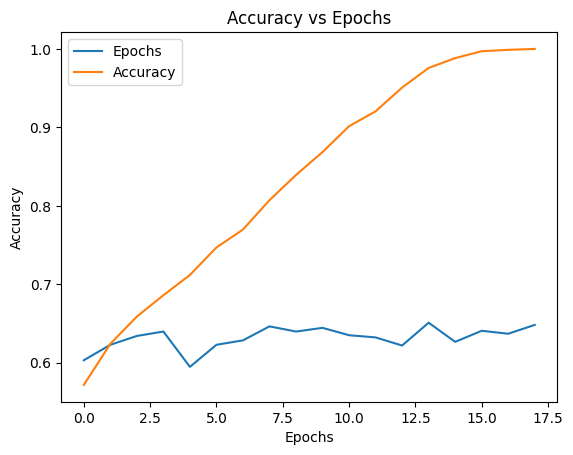

In [29]:
plot(validation_acc, train_acc, x_label="Epochs", y_label="Accuracy", title="Accuracy vs Epochs")